# PDFNet Demo with Test-Time Augmentation (TTA)

This notebook demonstrates PDFNet inference with MoGe depth estimation and optional TTA for improved accuracy.

## Features:
- ✅ **MoGe Integration**: Automatic depth map generation
- ✅ **TTA Support**: Test-Time Augmentation for better results
- ✅ **Robust Processing**: Handles invalid values and edge cases
- ✅ **Visual Comparison**: Side-by-side TTA vs Standard results


In [ ]:
# Setup and imports
# Standard library imports
import sys
import argparse
from pathlib import Path

# Third-party imports  
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import ttach as tta
from torch.amp.autocast_mode import autocast
from torchvision.transforms.functional import normalize
from moge.model.v2 import MoGeModel

# Add project root to Python path to ensure imports work
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Local imports (after path setup)
from src.pdfnet.models.PDFNet import build_model
from src.pdfnet.args import get_args_parser

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Load models
print("Loading PDFNet model...")
parser = argparse.ArgumentParser("PDFNet Testing script", parents=[get_args_parser()])
args = parser.parse_args(args=[])
model, model_name = build_model(args)
model.load_state_dict(
    torch.load(r"checkpoints/PDFNet_Best.pth", map_location="cpu"), strict=False
)
model = model.to(device).eval()

print("Loading MoGe model...")
moge_model = MoGeModel.from_pretrained("checkpoints/moge/moge-2-vitl-normal/model.pt")
moge_model = moge_model.to(device).eval()

print("✅ Models loaded successfully!")


Loading PDFNet model...
Loading MoGe model...
✅ Models loaded successfully!


In [ ]:
# Core functions
class GOSNormalize(object):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image = normalize(image, self.mean, self.std)
        return image


def process_image_with_moge(image_np, model, device):
    """Process a single image with MoGe to get depth map."""
    height, width = image_np.shape[:2]
    input_size = 518
    image_resized = cv2.resize(image_np, (input_size, input_size))

    # Convert to tensor
    image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float() / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        moge_output = model.infer(image_tensor)
        depth = moge_output["depth"]

        # Handle different depth formats
        if depth.dim() == 4:
            depth = depth.squeeze(0).squeeze(0)
        elif depth.dim() == 3:
            depth = depth.squeeze(0)
        elif depth.dim() == 1:
            depth = depth.view(input_size, input_size)

        # Resize back to original size
        depth = torch.nn.functional.interpolate(
            depth.unsqueeze(0).unsqueeze(0),
            size=(height, width),
            mode="bilinear",
            align_corners=False,
        ).squeeze()

        # Convert to numpy and normalize
        depth_np = depth.cpu().numpy()

        # Clean invalid values
        if np.isnan(depth_np).any() or np.isinf(depth_np).any():
            depth_np = np.nan_to_num(depth_np, nan=0.0, posinf=1.0, neginf=0.0)

        # Normalize to 0-255 range
        depth_min, depth_max = depth_np.min(), depth_np.max()
        if depth_min == depth_max:
            depth_normalized = np.full_like(depth_np, 128.0)
        else:
            depth_normalized = (depth_np - depth_min) / (depth_max - depth_min) * 255.0

        depth_normalized = np.clip(depth_normalized, 0, 255)
        return depth_normalized.astype(np.uint8)


def process_segmentation_output(DIS_map_tensor, target_width, target_height):
    """Process and clean segmentation output tensor for visualization"""
    DIS_map_np = DIS_map_tensor.numpy()

    # Clean up invalid values
    if np.isnan(DIS_map_np).any() or np.isinf(DIS_map_np).any():
        DIS_map_np = np.nan_to_num(DIS_map_np, nan=0.0, posinf=1.0, neginf=0.0)

    # Ensure proper data type and range
    DIS_map_np = np.clip(DIS_map_np, 0, 1)
    DIS_map_np = DIS_map_np.astype(np.float32)

    # Resize to target dimensions
    try:
        DIS_map_resized = cv2.resize(DIS_map_np, (target_width, target_height))
        return DIS_map_resized
    except Exception as e:
        print(f"Error during resize: {e}")
        return DIS_map_np


print("✅ Core functions defined!")


✅ Core functions defined!


In [ ]:
# TTA Implementation
class PDFNetTTAWrapper(torch.nn.Module):
    """TTA Wrapper for PDFNet that handles dual input (image + depth)"""

    def __init__(self, model, tta_transforms):
        super().__init__()
        self.model = model
        self.tta_transforms = tta_transforms

    def forward(self, image, depth):
        predictions = []

        for transform in self.tta_transforms:
            # Transform both inputs
            aug_image = transform.augment_image(image)
            aug_depth = transform.augment_image(depth)

            # Get prediction
            with torch.no_grad():
                pred_output = self.model.inference(aug_image, aug_depth)

                # Extract main prediction tensor
                if isinstance(pred_output, (list, tuple)):
                    pred = pred_output[0]
                else:
                    pred = pred_output

                while isinstance(pred, (list, tuple)) and len(pred) > 0:
                    pred = pred[0]

            # Reverse transform on prediction
            pred_deaug = transform.deaugment_mask(pred)
            predictions.append(pred_deaug)

        # Average all predictions
        if predictions:
            final_pred = torch.stack(predictions).mean(dim=0)
            return final_pred
        else:
            raise ValueError("No predictions were generated during TTA")


def create_tta_transforms():
    """Create TTA transforms for PDFNet"""
    return tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
        ]
    )


def run_pdfnet_inference_with_tta(
    model, image_tensor, depth_tensor, device, use_tta=True
):
    """Enhanced PDFNet inference with optional TTA and fallback"""
    if use_tta:
        try:
            # Create TTA wrapper
            tta_transforms = create_tta_transforms()
            tta_model = PDFNetTTAWrapper(model, tta_transforms)

            # Run TTA inference
            with autocast(enabled=torch.cuda.is_available(), device_type="cuda"):
                result = tta_model(image_tensor, depth_tensor)

            if isinstance(result, torch.Tensor) and result.numel() > 0:
                return result
            else:
                print("⚠️ TTA result is empty, falling back to standard inference")
                use_tta = False
        except Exception as e:
            print(f"⚠️ TTA inference failed: {e}")
            print("Falling back to standard inference...")
            use_tta = False

    if not use_tta:
        # Standard inference
        with torch.no_grad():
            with autocast(enabled=torch.cuda.is_available(), device_type="cuda"):
                result = model.inference(image_tensor, depth_tensor)

    return result


print("✅ TTA functions defined!")


✅ TTA functions defined!


In [ ]:
# Main demo function
def run_pdfnet_demo(image_path="pics/37.png", use_tta=True):
    """Complete PDFNet demo with MoGe depth estimation and optional TTA"""

    print(f"Processing: {image_path}")
    print(f"TTA enabled: {use_tta}")

    # Load and prepare image
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Could not load image: {image_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]
    print(f"Image size: {W}x{H}")

    # Generate depth map
    print("Generating depth map...")
    depth = process_image_with_moge(img, moge_model, device)

    # Resize for model input
    img_resized = cv2.resize(img, (1024, 1024))
    depth_resized = cv2.resize(depth, (1024, 1024))

    # Prepare tensors
    transforms = GOSNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255
    img_tensor = transforms(img_tensor).unsqueeze(0)
    depth_tensor = torch.from_numpy(depth_resized).unsqueeze(0).unsqueeze(0) / 255

    # Run inference
    print(f"Running PDFNet inference {'with TTA' if use_tta else '(standard)'}...")

    if use_tta:
        tta_result = run_pdfnet_inference_with_tta(
            model, img_tensor.to(device), depth_tensor.to(device), device, use_tta=True
        )
        # TTA returns tensor directly
        if isinstance(tta_result, torch.Tensor):
            DIS_map = tta_result[0][0].cpu()
        else:
            DIS_map = tta_result[0][0][0].cpu()
    else:
        with torch.no_grad():
            standard_result = model.inference(
                img_tensor.to(device), depth_tensor.to(device)
            )
        DIS_map = standard_result[0][0][0].cpu()

    # Process output
    DIS_map_final = process_segmentation_output(DIS_map, W, H)

    # Visualize results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(depth, cmap="plasma")
    plt.title("MoGe Depth Map")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(DIS_map_final, cmap="gray")
    plt.title(f"PDFNet Result {'(TTA)' if use_tta else '(Standard)'}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("✅ Processing completed!")
    return DIS_map_final


print("✅ Demo function ready!")


✅ Demo function ready!


In [3]:
# Run demo with TTA
result_tta = run_pdfnet_demo(image_path="pics/01.png", use_tta=True)


Processing: pics/01.png
TTA enabled: True


NameError: name 'cv2' is not defined

In [ ]:
# Run demo without TTA for comparison
result_standard = run_pdfnet_demo(image_path="pics/37.png", use_tta=False)


In [ ]:
# Compare TTA vs Standard results
if result_tta is not None and result_standard is not None:
    diff = np.abs(result_tta.astype(float) - result_standard.astype(float))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(result_standard, cmap="gray")
    plt.title("Standard Result")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(result_tta, cmap="gray")
    plt.title("TTA Result")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(diff, cmap="hot")
    plt.title("Difference Map")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Mean absolute difference: {diff.mean():.6f}")
    print(f"Max absolute difference: {diff.max():.6f}")

    # Calculate correlation
    flat_tta = result_tta.flatten().astype(float)
    flat_std = result_standard.flatten().astype(float)
    correlation = np.corrcoef(flat_tta, flat_std)[0, 1]
    print(f"Correlation: {correlation:.6f}")
else:
    print("❌ Could not compare results - one or both failed")


In [ ]:
# Speed Benchmarking
import time
from statistics import mean, stdev


def benchmark_inference_speed(image_path="pics/37.png", num_runs=100, warmup_runs=5):
    """Benchmark PDFNet inference speed with and without TTA"""

    print("🏁 BENCHMARKING INFERENCE SPEED")
    print(f"Image: {image_path}")
    print(f"Runs: {num_runs} (+ {warmup_runs} warmup)")
    print("=" * 60)

    # Load and prepare image once
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Could not load image: {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    # Generate depth map once
    print("Preparing test data...")
    depth = process_image_with_moge(img, moge_model, device)

    # Prepare tensors once
    img_resized = cv2.resize(img, (1024, 1024))
    depth_resized = cv2.resize(depth, (1024, 1024))

    transforms = GOSNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255
    img_tensor = transforms(img_tensor).unsqueeze(0).to(device)
    depth_tensor = (
        torch.from_numpy(depth_resized).unsqueeze(0).unsqueeze(0).to(device) / 255
    )

    print("✅ Test data prepared")

    # Function to run standard inference
    def run_standard():
        with torch.no_grad():
            with autocast(enabled=torch.cuda.is_available(), device_type="cuda"):
                result = model.inference(img_tensor, depth_tensor)
        return result

    # Function to run TTA inference
    def run_tta():
        tta_transforms = create_tta_transforms()
        tta_model = PDFNetTTAWrapper(model, tta_transforms)
        with autocast(enabled=torch.cuda.is_available(), device_type="cuda"):
            result = tta_model(img_tensor, depth_tensor)
        return result

    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    # BENCHMARK STANDARD INFERENCE
    print("\\n🔬 BENCHMARKING STANDARD INFERENCE")
    print("-" * 40)

    # Warmup runs
    print(f"Warming up ({warmup_runs} runs)...")
    for _ in range(warmup_runs):
        _ = run_standard()
        if torch.cuda.is_available():
            torch.cuda.synchronize()

    # Actual benchmark runs
    print(f"Running benchmark ({num_runs} runs)...")
    standard_times = []

    for i in range(num_runs):
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        start_time = time.time()
        run_standard()

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        end_time = time.time()
        elapsed = end_time - start_time
        standard_times.append(elapsed)

        if (i + 1) % 20 == 0:
            print(f"  Progress: {i + 1}/{num_runs} runs completed")

    # Calculate statistics
    std_mean = mean(standard_times)
    std_std = stdev(standard_times) if len(standard_times) > 1 else 0
    std_min = min(standard_times)
    std_max = max(standard_times)

    print("\\n📊 STANDARD INFERENCE RESULTS:")
    print(f"  Mean time: {std_mean:.4f}s")
    print(f"  Std dev:   {std_std:.4f}s")
    print(f"  Min time:  {std_min:.4f}s")
    print(f"  Max time:  {std_max:.4f}s")
    print(f"  FPS:       {1/std_mean:.2f}")

    # Clear GPU cache before TTA benchmark
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    # BENCHMARK TTA INFERENCE
    print("\\n🔄 BENCHMARKING TTA INFERENCE")
    print("-" * 40)

    # Warmup runs
    print(f"Warming up ({warmup_runs} runs)...")
    for _ in range(warmup_runs):
        _ = run_tta()
        if torch.cuda.is_available():
            torch.cuda.synchronize()

    # Actual benchmark runs
    print(f"Running benchmark ({num_runs} runs)...")
    tta_times = []

    for i in range(num_runs):
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        start_time = time.time()
        run_tta()

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        end_time = time.time()
        elapsed = end_time - start_time
        tta_times.append(elapsed)

        if (i + 1) % 20 == 0:
            print(f"  Progress: {i + 1}/{num_runs} runs completed")

    # Calculate statistics
    tta_mean = mean(tta_times)
    tta_std = stdev(tta_times) if len(tta_times) > 1 else 0
    tta_min = min(tta_times)
    tta_max = max(tta_times)

    print("\\n📊 TTA INFERENCE RESULTS:")
    print(f"  Mean time: {tta_mean:.4f}s")
    print(f"  Std dev:   {tta_std:.4f}s")
    print(f"  Min time:  {tta_min:.4f}s")
    print(f"  Max time:  {tta_max:.4f}s")
    print(f"  FPS:       {1/tta_mean:.2f}")

    # COMPARISON
    print("\\n⚖️ COMPARISON:")
    print("-" * 40)
    speedup_factor = tta_mean / std_mean
    print(f"  TTA is {speedup_factor:.2f}x slower than standard")
    print(f"  TTA overhead: +{(tta_mean - std_mean):.4f}s per inference")
    print(f"  Standard throughput: {1/std_mean:.2f} FPS")
    print(f"  TTA throughput:      {1/tta_mean:.2f} FPS")

    # VISUALIZATION
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))

    # Time distribution plots
    plt.subplot(1, 3, 1)
    plt.hist(standard_times, bins=20, alpha=0.7, label="Standard", color="blue")
    plt.hist(tta_times, bins=20, alpha=0.7, label="TTA", color="red")
    plt.xlabel("Inference Time (seconds)")
    plt.ylabel("Frequency")
    plt.title("Inference Time Distribution")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Box plot comparison
    plt.subplot(1, 3, 2)
    plt.boxplot([standard_times, tta_times], labels=["Standard", "TTA"])
    plt.ylabel("Inference Time (seconds)")
    plt.title("Inference Time Comparison")
    plt.grid(True, alpha=0.3)

    # Time series plot
    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_runs + 1), standard_times, "b-", alpha=0.7, label="Standard")
    plt.plot(range(1, num_runs + 1), tta_times, "r-", alpha=0.7, label="TTA")
    plt.xlabel("Run Number")
    plt.ylabel("Inference Time (seconds)")
    plt.title("Inference Time Over Runs")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return results
    return {
        "standard": {
            "times": standard_times,
            "mean": std_mean,
            "std": std_std,
            "min": std_min,
            "max": std_max,
            "fps": 1 / std_mean,
        },
        "tta": {
            "times": tta_times,
            "mean": tta_mean,
            "std": tta_std,
            "min": tta_min,
            "max": tta_max,
            "fps": 1 / tta_mean,
        },
        "comparison": {
            "tta_slowdown": speedup_factor,
            "overhead_seconds": tta_mean - std_mean,
        },
    }


print("✅ Benchmarking function ready!")


✅ Benchmarking function ready!


🏁 BENCHMARKING INFERENCE SPEED
Image: pics/37.png
Runs: 100 (+ 5 warmup)
Preparing test data...
✅ Test data prepared
\n🔬 BENCHMARKING STANDARD INFERENCE
----------------------------------------
Warming up (5 runs)...
Running benchmark (100 runs)...
  Progress: 20/100 runs completed
  Progress: 40/100 runs completed
  Progress: 60/100 runs completed
  Progress: 80/100 runs completed
  Progress: 100/100 runs completed
\n📊 STANDARD INFERENCE RESULTS:
  Mean time: 0.2372s
  Std dev:   0.0307s
  Min time:  0.1970s
  Max time:  0.2840s
  FPS:       4.22
\n🔄 BENCHMARKING TTA INFERENCE
----------------------------------------
Warming up (5 runs)...
Running benchmark (100 runs)...
  Progress: 20/100 runs completed
  Progress: 40/100 runs completed
  Progress: 60/100 runs completed
  Progress: 80/100 runs completed
  Progress: 100/100 runs completed
\n📊 TTA INFERENCE RESULTS:
  Mean time: 0.7864s
  Std dev:   0.0283s
  Min time:  0.7582s
  Max time:  0.8670s
  FPS:       1.27
\n⚖️ COMPARISON:
--

C:\Users\opsiclear\AppData\Local\Temp\ipykernel_44616\1817418810.py:178: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([standard_times, tta_times], labels=['Standard', 'TTA'])


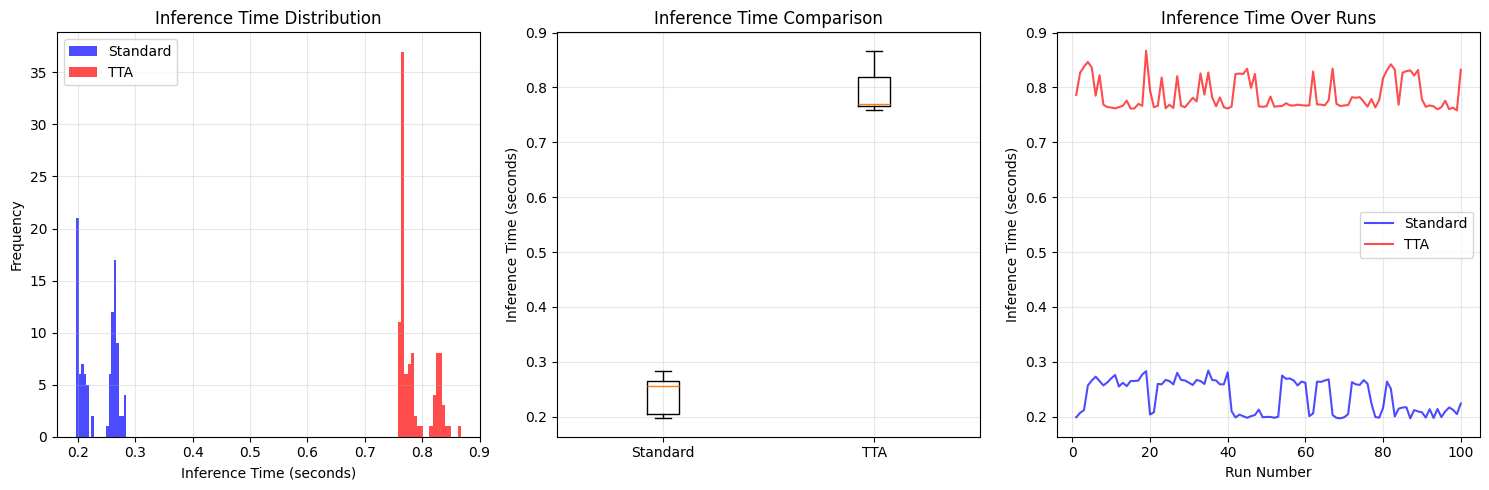

In [ ]:
# Run speed benchmark
benchmark_results = benchmark_inference_speed(
    image_path="pics/37.png", num_runs=100, warmup_runs=5
)


In [ ]:
# Optional: Detailed benchmark analysis
if "benchmark_results" in locals() and benchmark_results is not None:
    print("📈 DETAILED BENCHMARK ANALYSIS")
    print("=" * 50)

    std_results = benchmark_results["standard"]
    tta_results = benchmark_results["tta"]
    comparison = benchmark_results["comparison"]

    print("\\n🔬 STANDARD INFERENCE ANALYSIS:")
    print(f"  Fastest run:    {std_results['min']:.4f}s")
    print(f"  Slowest run:    {std_results['max']:.4f}s")
    print(f"  Average:        {std_results['mean']:.4f}s ± {std_results['std']:.4f}s")
    print(
        f"  Coefficient of variation: {(std_results['std']/std_results['mean']*100):.2f}%"
    )
    print(f"  Throughput:     {std_results['fps']:.2f} FPS")

    print("\\n🔄 TTA INFERENCE ANALYSIS:")
    print(f"  Fastest run:    {tta_results['min']:.4f}s")
    print(f"  Slowest run:    {tta_results['max']:.4f}s")
    print(f"  Average:        {tta_results['mean']:.4f}s ± {tta_results['std']:.4f}s")
    print(
        f"  Coefficient of variation: {(tta_results['std']/tta_results['mean']*100):.2f}%"
    )
    print(f"  Throughput:     {tta_results['fps']:.2f} FPS")

    print("\\n⚖️ PERFORMANCE COMPARISON:")
    print(f"  TTA Slowdown:   {comparison['tta_slowdown']:.2f}x")
    print(f"  Time Overhead:  +{comparison['overhead_seconds']:.4f}s per inference")
    print(
        f"  Throughput Loss: -{((std_results['fps'] - tta_results['fps'])/std_results['fps']*100):.1f}%"
    )

    # Performance categories
    if comparison["tta_slowdown"] < 2.0:
        perf_category = "🟢 Excellent (< 2x slower)"
    elif comparison["tta_slowdown"] < 3.0:
        perf_category = "🟡 Good (2-3x slower)"
    elif comparison["tta_slowdown"] < 5.0:
        perf_category = "🟠 Acceptable (3-5x slower)"
    else:
        perf_category = "🔴 Poor (> 5x slower)"

    print(f"\\n🎯 TTA PERFORMANCE RATING: {perf_category}")

    # Memory usage estimate (if CUDA available)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

        # Run one inference to measure memory
        img = cv2.imread("pics/37.png")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        depth = process_image_with_moge(img, moge_model, device)
        img_resized = cv2.resize(img, (1024, 1024))
        depth_resized = cv2.resize(depth, (1024, 1024))

        transforms = GOSNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255
        img_tensor = transforms(img_tensor).unsqueeze(0).to(device)
        depth_tensor = (
            torch.from_numpy(depth_resized).unsqueeze(0).unsqueeze(0).to(device) / 255
        )

        # Measure standard inference memory
        torch.cuda.reset_peak_memory_stats()
        with torch.no_grad():
            _ = model.inference(img_tensor, depth_tensor)
        std_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB

        # Measure TTA inference memory
        torch.cuda.reset_peak_memory_stats()
        tta_transforms = create_tta_transforms()
        tta_model = PDFNetTTAWrapper(model, tta_transforms)
        _ = tta_model(img_tensor, depth_tensor)
        tta_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB

        print("\\n💾 MEMORY USAGE:")
        print(f"  Standard inference: {std_memory:.1f} MB")
        print(f"  TTA inference:      {tta_memory:.1f} MB")
        print(
            f"  Memory overhead:    +{tta_memory - std_memory:.1f} MB ({((tta_memory/std_memory-1)*100):.1f}%)"
        )

        torch.cuda.empty_cache()

    print("\\n🚀 RECOMMENDATIONS:")
    if comparison["tta_slowdown"] < 3.0:
        print("  ✅ TTA provides good accuracy improvement with acceptable speed cost")
        print("  ✅ Suitable for production use where quality > speed")
    else:
        print("  ⚠️ TTA has significant speed overhead")
        print("  ⚠️ Consider using only for final/critical results")

    if std_results["fps"] > 10:
        print("  ✅ Standard inference is real-time capable (>10 FPS)")
    elif std_results["fps"] > 1:
        print("  🟡 Standard inference is suitable for batch processing")
    else:
        print("  🔴 Standard inference is slow - consider optimization")

else:
    print("❌ No benchmark results available. Run the benchmark first!")


In [ ]:
# Batch Processing Support
def process_batch_with_moge(image_batch, model, device):
    """Process a batch of images with MoGe to get depth maps."""
    batch_size = image_batch.shape[0]
    input_size = 518

    # Resize all images in batch
    images_resized = torch.nn.functional.interpolate(
        image_batch, size=(input_size, input_size), mode="bilinear", align_corners=False
    )

    # Run batch inference
    with torch.no_grad():
        moge_output = model.infer(images_resized)
        depth_batch = moge_output["depth"]

        # Handle different depth formats
        if depth_batch.dim() == 4 and depth_batch.shape[1] == 1:
            depth_batch = depth_batch.squeeze(1)  # Remove channel dim if present
        elif depth_batch.dim() == 3:
            pass  # Already correct format (B, H, W)

        # Clean invalid values for entire batch
        depth_batch_np = depth_batch.cpu().numpy()
        if np.isnan(depth_batch_np).any() or np.isinf(depth_batch_np).any():
            depth_batch_np = np.nan_to_num(
                depth_batch_np, nan=0.0, posinf=1.0, neginf=0.0
            )

        # Normalize each image in batch individually
        normalized_batch = []
        for i in range(batch_size):
            depth_np = depth_batch_np[i]
            depth_min, depth_max = depth_np.min(), depth_np.max()
            if depth_min == depth_max:
                depth_normalized = np.full_like(depth_np, 128.0)
            else:
                depth_normalized = (
                    (depth_np - depth_min) / (depth_max - depth_min) * 255.0
                )

            depth_normalized = np.clip(depth_normalized, 0, 255)
            normalized_batch.append(depth_normalized.astype(np.uint8))

        return np.stack(normalized_batch)


def run_pdfnet_batch_inference(image_batch, depth_batch, model, device, use_tta=False):
    """Run PDFNet inference on a batch of images"""
    batch_size = image_batch.shape[0]

    if use_tta:
        # TTA with batch processing
        tta_transforms = create_tta_transforms()
        predictions = []

        for transform in tta_transforms:
            # Transform entire batch
            aug_image_batch = torch.stack(
                [
                    transform.augment_image(img.unsqueeze(0)).squeeze(0)
                    for img in image_batch
                ]
            )
            aug_depth_batch = torch.stack(
                [
                    transform.augment_image(depth.unsqueeze(0)).squeeze(0)
                    for depth in depth_batch
                ]
            )

            # Run batch inference
            with torch.no_grad():
                with autocast(enabled=torch.cuda.is_available(), device_type="cuda"):
                    pred_output = model.inference(aug_image_batch, aug_depth_batch)

                # Extract main prediction tensor
                if isinstance(pred_output, (list, tuple)):
                    pred = pred_output[0]
                else:
                    pred = pred_output

            # Reverse transform for each image in batch
            deaug_batch = torch.stack(
                [
                    transform.deaugment_mask(pred[i : i + 1]).squeeze(0)
                    for i in range(batch_size)
                ]
            )
            predictions.append(deaug_batch)

        # Average all predictions
        final_pred = torch.stack(predictions).mean(dim=0)
        return final_pred
    else:
        # Standard batch inference
        with torch.no_grad():
            with autocast(enabled=torch.cuda.is_available(), device_type="cuda"):
                result = model.inference(image_batch, depth_batch)
        return result


def batch_demo(image_paths, batch_size=4, use_tta=False):
    """Demo function for batch processing multiple images"""

    print("🚀 BATCH PROCESSING DEMO")
    print(f"Images: {len(image_paths)}")
    print(f"Batch size: {batch_size}")
    print(f"TTA enabled: {use_tta}")
    print("=" * 60)

    # Process images in batches
    all_results = []
    total_batches = (len(image_paths) + batch_size - 1) // batch_size

    for batch_idx in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[batch_idx : batch_idx + batch_size]
        current_batch_size = len(batch_paths)

        print(
            f"\\nProcessing batch {(batch_idx // batch_size) + 1}/{total_batches} ({current_batch_size} images)"
        )

        # Load and prepare batch
        batch_images = []
        batch_original_sizes = []

        for img_path in batch_paths:
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Could not load {img_path}, skipping...")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            H, W = img.shape[:2]
            batch_original_sizes.append((W, H))

            # Resize and normalize
            img_resized = cv2.resize(img, (1024, 1024))
            img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255
            batch_images.append(img_tensor)

        if not batch_images:
            continue

        # Stack into batch
        image_batch = torch.stack(batch_images).to(device)

        # Generate depth maps for batch
        print("  Generating depth maps...")
        # Convert back to numpy for MoGe processing
        image_batch_np = (image_batch.cpu().numpy() * 255).astype(np.uint8)
        image_batch_np = image_batch_np.transpose(0, 2, 3, 1)  # BCHW -> BHWC

        depth_batch_list = []
        for img_np in image_batch_np:
            depth = process_image_with_moge(img_np, moge_model, device)
            depth_resized = cv2.resize(depth, (1024, 1024))
            depth_batch_list.append(depth_resized)

        depth_batch = (
            torch.from_numpy(np.stack(depth_batch_list)).unsqueeze(1).to(device) / 255
        )

        # Apply normalization
        transforms = GOSNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        normalized_batch = torch.stack([transforms(img) for img in image_batch])

        # Run batch inference
        print(
            f"  Running PDFNet inference {'with TTA' if use_tta else '(standard)'}..."
        )

        start_time = time.time()
        result_batch = run_pdfnet_batch_inference(
            normalized_batch, depth_batch, model, device, use_tta
        )
        inference_time = time.time() - start_time

        # Process results
        if isinstance(result_batch, (list, tuple)):
            result_batch = result_batch[0]

        # Extract and resize results back to original sizes
        for i, (img_path, (W, H)) in enumerate(zip(batch_paths, batch_original_sizes)):
            if i >= result_batch.shape[0]:
                break

            result_tensor = result_batch[i]
            if result_tensor.dim() == 3:
                result_tensor = result_tensor[0]  # Remove channel dim

            result_np = result_tensor.cpu().numpy()
            result_resized = cv2.resize(result_np, (W, H))

            all_results.append(
                {"path": img_path, "result": result_resized, "original_size": (W, H)}
            )

        print(
            f"  ✅ Batch completed in {inference_time:.3f}s ({inference_time/current_batch_size:.3f}s per image)"
        )

        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(
        f"\\n🎉 Batch processing completed! Processed {len(all_results)} images total"
    )

    # Show sample results
    if all_results:
        num_show = min(4, len(all_results))
        fig, axes = plt.subplots(2, num_show, figsize=(4 * num_show, 8))
        if num_show == 1:
            axes = axes.reshape(2, 1)

        for i in range(num_show):
            result_data = all_results[i]

            # Load original image
            img = cv2.imread(result_data["path"])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Show original
            axes[0, i].imshow(img)
            axes[0, i].set_title(f"Original\\n{Path(result_data['path']).name}")
            axes[0, i].axis("off")

            # Show result
            axes[1, i].imshow(result_data["result"], cmap="gray")
            axes[1, i].set_title(f"Result {'(TTA)' if use_tta else '(Standard)'}")
            axes[1, i].axis("off")

        plt.tight_layout()
        plt.show()

    return all_results


print("✅ Batch processing functions ready!")


✅ Batch processing functions ready!


In [ ]:
# Demo batch processing with multiple images
import glob

# Find all images in pics folder
image_paths = (
    glob.glob("pics/*.png") + glob.glob("pics/*.jpg") + glob.glob("pics/*.jpeg")
)
print(
    f"Found {len(image_paths)} images: {[Path(p).name for p in image_paths[:5]]}{'...' if len(image_paths) > 5 else ''}"
)

# Run batch processing demo
if image_paths:
    batch_results = batch_demo(
        image_paths=image_paths[:8],  # Process first 8 images
        batch_size=4,
        use_tta=False,  # Set to True for TTA batch processing
    )
else:
    print("❌ No images found in pics/ folder")


Found 6 images: ['01.png', '37.png', 'Framwork.png', 'pic.png', 'vcompare.png']...
🚀 BATCH PROCESSING DEMO
Images: 6
Batch size: 4
TTA enabled: False
\nProcessing batch 1/2 (4 images)
  Generating depth maps...
  Running PDFNet inference (standard)...


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4086: error: (-215:Assertion failed) func != 0 in function 'cv::hal::resize'


In [ ]:
# Batch Performance Test with Same Image Stack
def benchmark_batch_vs_individual(
    image_path="pics/37.png", batch_sizes=[1, 2, 4, 6], num_runs=10, use_tta=False
):
    """Compare batch processing vs individual processing performance"""

    print("🏁 BATCH vs INDIVIDUAL PERFORMANCE BENCHMARK")
    print(f"Image: {image_path}")
    print(f"Batch sizes: {batch_sizes}")
    print(f"Runs per test: {num_runs}")
    print(f"TTA enabled: {use_tta}")
    print("=" * 80)

    # Load and prepare the test image
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Could not load image: {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    # Generate depth map once
    print("Preparing test data...")
    depth = process_image_with_moge(img, moge_model, device)

    # Prepare single image tensors
    img_resized = cv2.resize(img, (1024, 1024))
    depth_resized = cv2.resize(depth, (1024, 1024))

    transforms = GOSNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255
    img_tensor = transforms(img_tensor).unsqueeze(0).to(device)
    depth_tensor = (
        torch.from_numpy(depth_resized).unsqueeze(0).unsqueeze(0).to(device) / 255
    )

    print("✅ Test data prepared")

    results = {}

    for batch_size in batch_sizes:
        print(f"\\n📊 TESTING BATCH SIZE: {batch_size}")
        print("-" * 50)

        # Create batch by stacking the same image
        image_batch = img_tensor.repeat(batch_size, 1, 1, 1)
        depth_batch = depth_tensor.repeat(batch_size, 1, 1, 1)

        print(f"Batch shapes - Image: {image_batch.shape}, Depth: {depth_batch.shape}")

        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        # BATCH PROCESSING TEST
        print(f"Testing batch processing ({num_runs} runs)...")
        batch_times = []

        # Warmup
        for _ in range(3):
            _ = run_pdfnet_batch_inference(
                image_batch, depth_batch, model, device, use_tta
            )
            if torch.cuda.is_available():
                torch.cuda.synchronize()

        # Actual benchmark
        for run in range(num_runs):
            if torch.cuda.is_available():
                torch.cuda.synchronize()

            start_time = time.time()

            if use_tta:
                run_pdfnet_batch_inference(
                    image_batch, depth_batch, model, device, use_tta=True
                )
            else:
                with torch.no_grad():
                    with autocast(
                        enabled=torch.cuda.is_available(), device_type="cuda"
                    ):
                        model.inference(image_batch, depth_batch)

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end_time = time.time()
            batch_times.append(end_time - start_time)

        batch_mean = mean(batch_times)
        batch_std = stdev(batch_times) if len(batch_times) > 1 else 0

        # INDIVIDUAL PROCESSING TEST (for comparison)
        print(
            f"Testing individual processing ({num_runs} runs x {batch_size} images)..."
        )
        individual_times = []

        # Warmup
        for _ in range(3):
            if use_tta:
                _ = run_pdfnet_inference_with_tta(
                    model, img_tensor, depth_tensor, device, use_tta=True
                )
            else:
                with torch.no_grad():
                    with autocast(
                        enabled=torch.cuda.is_available(), device_type="cuda"
                    ):
                        _ = model.inference(img_tensor, depth_tensor)
            if torch.cuda.is_available():
                torch.cuda.synchronize()

        # Actual benchmark
        for run in range(num_runs):
            if torch.cuda.is_available():
                torch.cuda.synchronize()

            start_time = time.time()

            # Process images individually
            for _ in range(batch_size):
                if use_tta:
                    run_pdfnet_inference_with_tta(
                        model, img_tensor, depth_tensor, device, use_tta=True
                    )
                else:
                    with torch.no_grad():
                        with autocast(
                            enabled=torch.cuda.is_available(), device_type="cuda"
                        ):
                            model.inference(img_tensor, depth_tensor)

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end_time = time.time()
            individual_times.append(end_time - start_time)

        individual_mean = mean(individual_times)
        individual_std = stdev(individual_times) if len(individual_times) > 1 else 0

        # Calculate metrics
        speedup = individual_mean / batch_mean
        batch_per_image = batch_mean / batch_size
        individual_per_image = individual_mean / batch_size

        results[batch_size] = {
            "batch_time": batch_mean,
            "batch_std": batch_std,
            "individual_time": individual_mean,
            "individual_std": individual_std,
            "speedup": speedup,
            "batch_per_image": batch_per_image,
            "individual_per_image": individual_per_image,
            "batch_fps": batch_size / batch_mean,
            "individual_fps": batch_size / individual_mean,
        }

        print(f"\\n📈 RESULTS FOR BATCH SIZE {batch_size}:")
        print(f"  Batch processing:      {batch_mean:.4f}s ± {batch_std:.4f}s")
        print(
            f"  Individual processing: {individual_mean:.4f}s ± {individual_std:.4f}s"
        )
        print(f"  Speedup:              {speedup:.2f}x")
        print(f"  Batch per image:      {batch_per_image:.4f}s")
        print(f"  Individual per image: {individual_per_image:.4f}s")
        print(f"  Batch throughput:     {batch_size / batch_mean:.2f} FPS")
        print(f"  Individual throughput: {batch_size / individual_mean:.2f} FPS")

    # VISUALIZATION
    print("\\n📊 PERFORMANCE SUMMARY")
    print("=" * 80)

    # Create comparison plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    batch_sizes_list = list(results.keys())
    batch_times = [results[bs]["batch_time"] for bs in batch_sizes_list]
    individual_times = [results[bs]["individual_time"] for bs in batch_sizes_list]
    speedups = [results[bs]["speedup"] for bs in batch_sizes_list]
    batch_fps = [results[bs]["batch_fps"] for bs in batch_sizes_list]
    individual_fps = [results[bs]["individual_fps"] for bs in batch_sizes_list]

    # Plot 1: Total processing time
    ax1.plot(
        batch_sizes_list,
        batch_times,
        "b-o",
        label="Batch Processing",
        linewidth=2,
        markersize=8,
    )
    ax1.plot(
        batch_sizes_list,
        individual_times,
        "r-s",
        label="Individual Processing",
        linewidth=2,
        markersize=8,
    )
    ax1.set_xlabel("Batch Size")
    ax1.set_ylabel("Total Time (seconds)")
    ax1.set_title("Total Processing Time Comparison")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale("log")

    # Plot 2: Speedup factor
    ax2.bar(batch_sizes_list, speedups, color="green", alpha=0.7)
    ax2.axhline(y=1.0, color="red", linestyle="--", alpha=0.7, label="No speedup")
    ax2.set_xlabel("Batch Size")
    ax2.set_ylabel("Speedup Factor")
    ax2.set_title("Batch Processing Speedup")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Per-image processing time
    per_image_batch = [results[bs]["batch_per_image"] for bs in batch_sizes_list]
    per_image_individual = [
        results[bs]["individual_per_image"] for bs in batch_sizes_list
    ]

    ax3.plot(
        batch_sizes_list,
        per_image_batch,
        "b-o",
        label="Batch (per image)",
        linewidth=2,
        markersize=8,
    )
    ax3.plot(
        batch_sizes_list,
        per_image_individual,
        "r-s",
        label="Individual (per image)",
        linewidth=2,
        markersize=8,
    )
    ax3.set_xlabel("Batch Size")
    ax3.set_ylabel("Time per Image (seconds)")
    ax3.set_title("Per-Image Processing Time")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Throughput (FPS)
    ax4.plot(
        batch_sizes_list,
        batch_fps,
        "b-o",
        label="Batch Throughput",
        linewidth=2,
        markersize=8,
    )
    ax4.plot(
        batch_sizes_list,
        individual_fps,
        "r-s",
        label="Individual Throughput",
        linewidth=2,
        markersize=8,
    )
    ax4.set_xlabel("Batch Size")
    ax4.set_ylabel("Throughput (FPS)")
    ax4.set_title("Processing Throughput Comparison")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\\n📋 DETAILED RESULTS TABLE:")
    print(
        f"{'Batch Size':<10} {'Batch Time':<12} {'Individual':<12} {'Speedup':<10} {'Batch FPS':<12} {'Individual FPS':<15}"
    )
    print("-" * 80)
    for bs in batch_sizes_list:
        r = results[bs]
        print(
            f"{bs:<10} {r['batch_time']:.4f}s{'':<4} {r['individual_time']:.4f}s{'':<4} {r['speedup']:.2f}x{'':<5} {r['batch_fps']:.2f}{'':<8} {r['individual_fps']:.2f}"
        )

    # Recommendations
    print("\\n🚀 RECOMMENDATIONS:")
    best_speedup_bs = max(batch_sizes_list, key=lambda bs: results[bs]["speedup"])
    best_fps_bs = max(batch_sizes_list, key=lambda bs: results[bs]["batch_fps"])

    print(
        f"  🏆 Best speedup: Batch size {best_speedup_bs} ({results[best_speedup_bs]['speedup']:.2f}x faster)"
    )
    print(
        f"  🚀 Best throughput: Batch size {best_fps_bs} ({results[best_fps_bs]['batch_fps']:.2f} FPS)"
    )

    if results[best_speedup_bs]["speedup"] > 2.0:
        print(
            f"  ✅ Excellent batch performance! Use batch size {best_speedup_bs} for optimal speed"
        )
    elif results[best_speedup_bs]["speedup"] > 1.5:
        print(
            f"  🟡 Good batch performance. Batch size {best_speedup_bs} provides decent speedup"
        )
    else:
        print(
            "  🔴 Limited batch benefits. Consider GPU memory constraints or model architecture"
        )

    return results


print("✅ Batch performance benchmark ready!")


✅ Batch performance benchmark ready!


In [ ]:
# Run batch performance benchmark
print("🚀 Starting batch performance benchmark...")
print("This will test batch sizes 1, 2, 4, 8 with the same image stacked")

batch_perf_results = benchmark_batch_vs_individual(
    image_path="pics/37.png",
    batch_sizes=[1, 2, 4, 6],  # Test different batch sizes (max 6)
    num_runs=10,  # 10 runs per test for statistical significance
    use_tta=False,  # Set to True to test TTA batch performance
)


🚀 Starting batch performance benchmark...
This will test batch sizes 1, 2, 4, 8 with the same image stacked


NameError: name 'benchmark_batch_vs_individual' is not defined

In [ ]:
# Optional: Test TTA batch performance (uncomment to run)
# print("🔄 Testing TTA batch performance...")
# print("Note: TTA batch processing uses more memory - using smaller batch sizes")

# tta_batch_perf_results = benchmark_batch_vs_individual(
#     image_path="pics/37.png",
#     batch_sizes=[1, 2, 4],     # Smaller batch sizes for TTA due to memory usage
#     num_runs=5,                # Fewer runs since TTA is slower
#     use_tta=True
# )

# Quick comparison between standard and TTA batch performance
if "batch_perf_results" in locals():
    print("\\n📊 BATCH PERFORMANCE SUMMARY:")
    print("=" * 60)

    for batch_size in [1, 2, 4, 6]:
        if batch_size in batch_perf_results:
            result = batch_perf_results[batch_size]
            print(f"Batch size {batch_size}:")
            print(f"  Speedup: {result['speedup']:.2f}x")
            print(f"  Throughput: {result['batch_fps']:.2f} FPS")
            print(f"  Per-image time: {result['batch_per_image']:.4f}s")

    # Find optimal batch size
    optimal_bs = max(
        batch_perf_results.keys(), key=lambda bs: batch_perf_results[bs]["speedup"]
    )
    optimal_result = batch_perf_results[optimal_bs]

    print("\\n🎯 OPTIMAL CONFIGURATION:")
    print(f"  Best batch size: {optimal_bs}")
    print(f"  Speedup achieved: {optimal_result['speedup']:.2f}x")
    print(f"  Throughput: {optimal_result['batch_fps']:.2f} FPS")
    print(
        f"  Memory efficiency: {optimal_result['batch_per_image']/optimal_result['individual_per_image']:.2f}x better per image"
    )

else:
    print("❌ No batch performance results available. Run the benchmark first!")
